# Pyro Crash Course – Generating and Exploring Synthetic Sensor Data

This notebook is the **second step** in the Pyro crash course.

In this tutorial, we:
- **Generate synthetic temperature measurements** from simulated thermistors
- Introduce realistic effects such as **device variability**, **systematic errors**, **nonlinearities**, and **random noise**
- Use **PyTorch + Pyro** to create the data probabilistically
- Produce plots to **visualize how different effects shape the data**

The dataset we build here will serve as input for all future modeling stages.

For this, do the following:
   1. Imports and definitions
   2. Generate ground truth temperatures
   3. Generate linear responses per thermistor
   4. Add a gross error to one thermistor
   5. Add nonlinear trend function
   6. Add noise to dataset
   7. Plots and illustrations
   8. Preliminary interpretations
    
---

> ⚠️ While we control the generative process, our future models will treat the data as "raw measurements" — the ground truth is hidden.  
> This gives us an excellent basis for evaluating how well our probabilistic models uncover the structure we planted.

---

```
*This notebook and series are created for educational purposes by Dr. Jemil Avers Butt, Atlas Optimization GmbH – [www.atlasoptimization.com](https://www.atlasoptimization.com).*
```


**Scenario:**  
You are calibrating a batch of 5 thermistors in a climate chamber. The chamber generates a perfectly controlled linear temperature ramp from 10 to 20 °C. Each sensor responds differently due to manufacturing variation, and we simulate several sources of error.


## 1. Imports and definitions

Here we import `pyro`, `torch`, and `matplotlib`.

Even though this notebook doesn't perform inference, we use Pyro to sample from distributions — staying within the probabilistic mindset from the beginning.

We define:
- `n_device`: the number of thermistors
- `n_measure`: how many readings we take per device
- `n_faulty`: how many devices are deliberately broken
- `T_low`, `T_high`: the climate chamber ramp range

We also set random seeds for full reproducibility.


In [9]:
"""
    1. Imports and definitions
"""

# i) Imports
import pyro
import torch
import pandas
import matplotlib.pyplot as plt

# ii) Definitions
n_device = 5
n_measure = 100
T_low = 10
T_high = 20
n_faulty = 1

pyro.set_rng_seed(0)


## 2. Generate ground truth temperature

We simulate the true ambient temperature inside the climate chamber.

It linearly increases from `T_low` to `T_high`.  
We duplicate this signal for all thermistors so they all "saw" the same temperature.

$$
T_{\text{true}}(t) = \text{linspace}(T_{\text{low}}, T_{\text{high}}, N)
$$


In [10]:
"""
    2. Generate ground truth temperatures
"""

# i) Ground truth temperature
T_true = torch.linspace(T_low, T_high, n_measure)
T_true = T_true.repeat([n_device,1])


## 3. Generate linear responses per thermistor

Each thermistor transforms the true temperature into a raw reading via a simple linear model:

$$
T_{\text{measured}}^{(i)} = \alpha_0^{(i)} + \alpha_1^{(i)} \cdot T_{\text{true}}
$$

Where:
- $\alpha_0^{(i)}$: offset (bias) of sensor *i*
- $\alpha_1^{(i)}$: sensitivity or scaling error of sensor *i*

These parameters are sampled from Gaussian distributions to reflect manufacturing variation. This introduces **heterogeneity** across devices.


In [11]:
"""
    3. Generate linear responses per thermistor
"""

# i) Define prior distributions for alpha_0, alpha_1
mu_alpha_0 = torch.zeros([n_device,1])
sigma_alpha_0 = 0.1*torch.ones([n_device,1])
mu_alpha_1 = torch.ones([n_device,1])
sigma_alpha_1 = 0.1*torch.ones([n_device,1])

alpha_0_dist = pyro.distributions.Normal(loc = mu_alpha_0, scale = sigma_alpha_0)
alpha_1_dist = pyro.distributions.Normal(loc = mu_alpha_1, scale = sigma_alpha_1)

# ii) Sample to generate offsets and scales
alpha_0 = pyro.sample('alpha_0', alpha_0_dist)
alpha_1 = pyro.sample('alpha_1', alpha_1_dist)

# iii) Generate linear responses to T_true
T_meas_lin = alpha_0 + alpha_1 * T_true


## 4. Add a gross error to one thermistor

We simulate a fault in one sensor (e.g., miscalibration, damaged circuitry) by adding a large offset:

$$
T_{\text{measured}}^{(0)} \leftarrow T_{\text{measured}}^{(0)} + 5
$$

This will help test whether future models can identify **outlier behavior** or classify this sensor differently.


In [12]:
"""
    4. Add a gross error to one thermistor
"""

# i) Dataset nr 1 contains a gross error
index_gross = 0
impact_gross = torch.zeros([n_device, n_measure])
impact_gross[index_gross, : ] = 5 
T_meas_gross = T_meas_lin + impact_gross


## 5. Add nonlinear trend function

We now add a **temperature-dependent nonlinearity**, such as:
- self-heating,
- saturation,
- nonlinear resistance response.

This is modeled with a simple sine wave:
$$
T_{\text{nonlinear}} = T_{\text{gross}} + 0.5 \cdot \sin(T_{\text{true}})
$$

Visually, this bends the straight lines into curves.


In [17]:
"""
    5. Add nonlinear trend function
"""

# i) Overlay sine function
nonlinear_trend = 0.5*torch.sin(T_true)
T_meas_nonlinear = T_meas_gross + nonlinear_trend


## 6. Add noise to dataset

Finally, we inject uncorrelated noise to reflect electronic jitter or environmental perturbations.

Each measurement is perturbed with independent Gaussian noise:
$$
T_{\text{final}} = T_{\text{nonlinear}} + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.3)
$$

This gives us a **realistic-looking sensor dataset** with:
- structured device behavior,
- one faulty unit,
- nonlinear effects,
- stochastic variation.
This dataset can now be passed as an input to our sequence of modelling challenges - and we will always know how wrong we are exactly.


In [18]:
"""
    6. Add noise to dataset
"""

# i) Finally, add some noise
noise_dist = pyro.distributions.Normal(loc = torch.zeros([n_device, n_measure]), scale = 0.3)
noise = pyro.sample('noise', noise_dist)
T_meas_noisy = T_meas_nonlinear + noise


## 7. Visualization

We create five scatter plots to illustrate how each transformation progressively distorts the measurements.

- Plot 1: perfect identity (truth vs. truth)
- Plot 2: linear calibration effects
- Plot 3: gross error added
- Plot 4: nonlinear effect added
- Plot 5: noise added

This helps **build intuition** for what each model will try to recover.


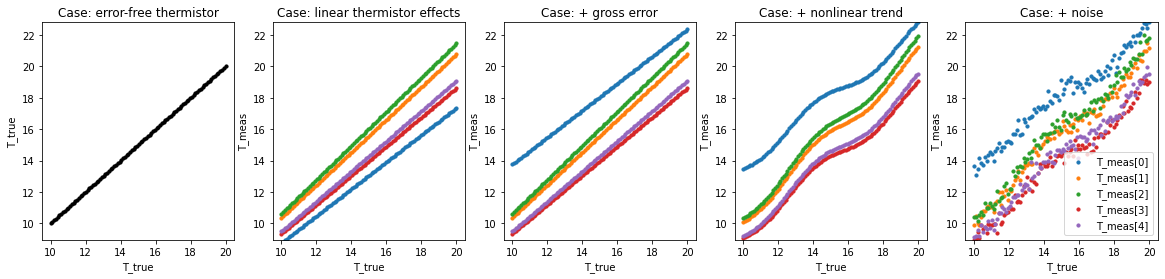

In [15]:
"""
    7. Plots and illustrations
"""

# i) Plot all of the data
# Here we illustrate the progression from ground truth towards evermore distorted
# data.

# Create the figure and 1x5 subplot grid
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=False, sharey=False)
# Global y-axis limits
y_min = min(T_true.min(), T_meas_noisy.min())
y_max = max(T_true.max(), T_meas_noisy.max())

# First plot: T_true vs T_true
axes[0].scatter(T_true[0,:], T_true[0,:], color='black', s=10)
axes[0].set_title("Case: error-free thermistor")
axes[0].set_xlabel("T_true")
axes[0].set_ylabel("T_true")
axes[0].set_ylim(y_min, y_max)

# Second plot: T_true vs T_meas_lin
for i in range(n_device):
    axes[1].scatter(T_true[i,:], T_meas_lin[i,:], s=10, label=f"T_meas[{i}]")
axes[1].set_title("Case: linear thermistor effects")
axes[1].set_xlabel("T_true")
axes[1].set_ylabel("T_meas")
axes[1].set_ylim(y_min, y_max)

# Third plot: T_true vs T_meas_gross
for i in range(n_device):
    axes[2].scatter(T_true[i,:], T_meas_gross[i,:], s=10, label=f"T_meas[{i}]")
axes[2].set_title("Case: + gross error")
axes[2].set_xlabel("T_true")
axes[2].set_ylabel("T_meas")
axes[2].set_ylim(y_min, y_max)


# Fourth plot: T_true vs T_meas_nonlinear
for i in range(n_device):
    axes[3].scatter(T_true[i,:], T_meas_nonlinear[i,:], s=10, label=f"T_meas[{i}]")
axes[3].set_title("Case: + nonlinear trend")
axes[3].set_xlabel("T_true")
axes[3].set_ylabel("T_meas")
axes[3].set_ylim(y_min, y_max)

# Fifth plot: T_true vs T_meas_noisy
for i in range(n_device):
    axes[4].scatter(T_true[i,:], T_meas_noisy[i,:], s=10, label=f"T_meas[{i}]")
axes[4].set_title("Case: + noise")
axes[4].set_xlabel("T_true")
axes[4].set_ylabel("T_meas")
axes[4].set_ylim(y_min, y_max)
axes[4].legend()


## 8. Preliminary interpretations and export

Now that we know how the data were generated, we can sketch what each of the upcoming models might "see" or struggle with:

| Model                      | What it can explain / What it can't |
|---------------------------|--------------------------------------|
| Model 0 – fixed params     | Captures average trend; misses device-level details |
| Model 1 – deterministic fit| Slightly better fit, but no uncertainty |
| Model 2 – latent variables | Quantifies uncertainty per parameter |
| Model 3 – hierarchical     | Learns per-device behavior (offset/slope) |
| Model 4 – discrete faults  | Should flag the broken sensor |
| Model 5 – neural network   | Can absorb nonlinearities; may overfit |

This table will serve as a **roadmap** through the next notebooks. Each new model will attempt to explain more of the structure we planted today.

We export now the data into a csv that will be imported in the next sessions, in which probabilistic models are built and tested against this data.


In [16]:
df = pandas.DataFrame({
    'sensor_id': torch.arange(n_device).repeat_interleave(n_measure).numpy(),
    'time_step': torch.arange(n_measure).tile(n_device).numpy(),
    'T_true': T_true.flatten().numpy(),
    'T_measured': T_meas_noisy.flatten().numpy()
})

output_path = "sensor_measurements.csv"
df.to_csv(output_path, index=False)


---

## 🧾 Summary

In this notebook, we:

✅ Generated synthetic sensor data from a set of thermistors  
✅ Built a ground-truth model with linear device variation, one gross error, a nonlinear trend, and Gaussian noise  
✅ Visualized each distortion step to understand how it changes the data  
✅ Created a realistic testbed for evaluating future probabilistic models

---

📌 In the next notebook, we'll define our **first generative model** and use Pyro's SVI to estimate its parameters from the dataset we've built here.
